In [94]:
# Load simulation data

import os
os.chdir('/home/scur2012/Thesis/master-thesis/experiments/network_training')

import zarr
import swyft.lightning as sl

zarr_store_dirs = '/scratch-shared/scur2012/peregrine_data/tmnre_experiments'
name_of_run = 'lstm_test_1'

rnd_id = 1
simulation_store_path = f"{zarr_store_dirs}/{name_of_run}/simulations/round_{rnd_id}"

zarr_store = sl.ZarrStore(f"{simulation_store_path}")

simulation_results = zarr.convenience.open(simulation_store_path)

In [95]:
# Settings for trainer and network

import importlib
import gw_parameters
importlib.reload(gw_parameters)

conf = gw_parameters.default_conf
bounds = gw_parameters.limits

intrinsic_variables = gw_parameters.intrinsic_variables
extrinsic_variables = gw_parameters.extrinsic_variables

trainer_settings = dict(
    min_epochs = 1,
    max_epochs = 1,
    early_stopping = 7,
    num_workers = 8,
    training_batch_size = 200,
    validation_batch_size = 200,
    train_split = 0.9,
    val_split = 0.1
)

network_settings = dict(
    # Peregrine
    shuffling = True,
    include_noise = False,
    priors = dict(
        int_priors = conf['priors']['int_priors'],
        ext_priors = conf['priors']['ext_priors'],
    ),
    marginals = ((0, 1),),
    one_d_only = True,
    ifo_list = conf["waveform_params"]["ifo_list"],
    learning_rate = 5e-4,
    training_batch_size = trainer_settings['training_batch_size'],
    save_path = '/home/scur2012/Thesis/master-thesis/experiments/network_training/roc_curve'
)


In [96]:
# Initialise dataloaders and setup trainer

import torch
torch.set_float32_matmul_precision('high')
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

train_data = zarr_store.get_dataloader(
    num_workers=trainer_settings['num_workers'],
    batch_size=trainer_settings['training_batch_size'],
    idx_range=[0, int(trainer_settings['train_split'] * len(zarr_store.data.z_int))],
    on_after_load_sample=False
)

val_data = zarr_store.get_dataloader(
    num_workers=trainer_settings['num_workers'],
    batch_size=trainer_settings['validation_batch_size'],
    idx_range=[
        int(trainer_settings['train_split'] * len(zarr_store.data.z_int)),
        len(zarr_store.data.z_int) - 1,
    ],
    on_after_load_sample=None
)

# Set up the pytorch trainer settings

tmp_dir = f"tmp_dir"

lr_monitor = LearningRateMonitor(logging_interval="step")
early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0,
    patience=trainer_settings["early_stopping"],
    verbose=False,
    mode="min",
)
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=f"{tmp_dir}",
    filename="{epoch}_{val_loss:.2f}_{train_loss:.2f}" + f"_round_{rnd_id+1}",
    mode="min",
)

# Make directory for logger
os.makedirs(f'{tmp_dir}/logs', exist_ok=True)
logger_tbl = pl_loggers.TensorBoardLogger(
    save_dir=f"{tmp_dir}",
    name=f"logs",
    version=None,
    default_hp_metric=False,
)

swyft_trainer = sl.SwyftTrainer(
    accelerator='gpu',
    devices=1,
    min_epochs=trainer_settings["min_epochs"],
    max_epochs=trainer_settings["max_epochs"],
    logger=logger_tbl,
    callbacks=[lr_monitor, early_stopping_callback, checkpoint_callback],
    enable_progress_bar = True
)


/home/scur2012/Thesis/master-thesis/.venv/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/scur2012/Thesis/master-thesis/.venv/lib/python ...
  rank_zero_warn(


In [97]:
# The network architecture
import numpy as np
import torch
from torch import nn
from torch.functional import F
from ResNet import ResNet50
from toolz.dicttoolz import valmap

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import swyft.lightning as sl
from vit_pytorch.simple_vit_1d import SimpleViT

import logging
logging.getLogger("pytorch_lightning.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("pytorch_lightning.accelerators.cuda").setLevel(logging.WARNING)


class InferenceNetwork(sl.SwyftModule):
    def __init__(self, **conf):
        super().__init__()
        self.one_d_only = conf["one_d_only"]
        self.batch_size = conf["training_batch_size"]
        self.noise_shuffling = conf["shuffling"]
        self.num_params = len(conf["priors"]["int_priors"].keys()) + len(
            conf["priors"]["ext_priors"].keys()
        )
        self.marginals = conf["marginals"]
        
        self.netw_t = Unet(
            n_in_channels=len(conf["ifo_list"]),
            n_out_channels=1,
            sizes=(16, 32, 64, 128, 256),
            down_sampling=(8, 8, 8, 8),
        )
        
        self.netw_f = Unet(
            n_in_channels=2 * len(conf["ifo_list"]),
            n_out_channels=1,
            sizes=(16, 32, 64, 128, 256),
            down_sampling=(2, 2, 2, 2),
        )

        self.flatten = nn.Flatten(1)
        self.linear_t = LinearCompression()
        self.linear_f = LinearCompression()

        self.logratios_1d = sl.LogRatioEstimator_1dim(
            num_features=32, num_params=int(self.num_params), varnames="z_total"
        )
        
        if not self.one_d_only:
            self.linear_t_2d = LinearCompression_2d()
            self.linear_f_2d = LinearCompression_2d()
            self.logratios_2d = sl.LogRatioEstimator_Ndim(
                num_features=256, marginals=self.marginals, varnames="z_total"
            )
            
        self.optimizer_init = sl.AdamOptimizerInit(lr=conf["learning_rate"])
        
        self.save_roc_path = conf["save_path"]
        self.include_noise = conf["include_noise"]

    def forward(self, batch):        
        
        A, B = self.get_A_B_samples(batch)
        
        if self.include_noise:
                   
            if self.noise_shuffling and A["d_t"].size(0) != 1:
                noise_shuffling = torch.randperm(self.batch_size)
                d_t = A["d_t"] + A["n_t"][noise_shuffling]
                d_f_w = A["d_f_w"] + A["n_f_w"][noise_shuffling]
            else:
                d_t = A["d_t"] + A["n_t"]
                d_f_w = A["d_f_w"] + A["n_f_w"]
        
        else:
            d_t = A["d_t"]
            d_f_w = A["d_f_w"]
        
        z_total = B["z_total"]

        d_t = self.netw_t(d_t)
        d_f_w = self.netw_f(d_f_w)
        flatten_t = self.flatten(d_t)
        flatten_f = self.flatten(d_f_w)
        features_t = self.linear_t(flatten_t)
        features_f = self.linear_f(flatten_f)
        
        features = torch.cat([features_t, features_f], dim=1)
        
        logratios_1d = self.logratios_1d(features, z_total)
        
        return logratios_1d

    def get_A_B_samples(self, batch):
        
        if isinstance(
            batch, list
        ):  # multiple dataloaders provided, using second one for contrastive samples
            A = batch[0]
            B = batch[1]
        else:  # only one dataloader provided, using same samples for constrative samples
            A = batch
            B = valmap(lambda z: torch.roll(z, 1, dims=0), A)

        # Concatenate positive samples and negative (contrastive) examples
        x = A
        z = {}
        for key in B:
            z[key] = torch.cat([A[key], B[key]])
            
        return x,z
            
    def training_step(self, batch, batch_idx):
        loss = self._calc_loss(batch)
        #self.log("train_loss", loss, on_step=True, on_epoch=False)
        return loss
            
    def validation_step(self, batch, batch_idx):
        loss = self._calc_loss(batch, randomized=False)
        # self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        # self.save_roc_curve(batch, batch_idx)
        
        return loss
    
    def predict_step(self, batch, *args, **kwargs):
        # A = batch[0]
        # B = batch[1]
        return self(batch)
    
    def _calc_loss(self, batch, randomized=True):
        """Calculate batch-averaged loss summed over ratio estimators.

        Note: The expected loss for an untrained classifier (with f = 0) is
        subtracted.  The initial loss is hence usually close to zero.
        """
        A, B = self.get_A_B_samples(batch)

        num_pos = len(list(A.values())[0])  # Number of positive examples
        num_neg = len(list(B.values())[0]) - num_pos  # Number of negative examples

        out = self(batch)  # Evaluate network
        loss_tot = 0

        logratios = self._get_logratios(
            out
        )  # Generates concatenated flattened list of all estimated log ratios
        if logratios is not None:
            y = torch.zeros_like(logratios)
            y[:num_pos, ...] = 1
            pos_weight = torch.ones_like(logratios[0]) * num_neg / num_pos
            loss = F.binary_cross_entropy_with_logits(
                logratios, y, reduction="none", pos_weight=pos_weight
            )
            
            # print (torch.mean(loss, axis=0) - np.log(2.0) )
            
            num_ratios = loss.shape[1]
            loss = loss.sum() / num_neg  # Calculates batched-averaged loss
            loss = loss - 2 * np.log(2.0) * num_ratios
                        
            loss_tot += loss

        # print (loss_tot)

        aux_losses = self._get_aux_losses(out)
        if aux_losses is not None:
            loss_tot += aux_losses.sum()

        return loss_tot
    
    def get_logratios_probabilities(self, batch):
        
        A, B = self.get_A_B_samples(batch)

        num_pos = len(list(A.values())[0])  # Number of positive examples
        num_neg = len(list(B.values())[0]) - num_pos  # Number of negative examples

        out = self(batch)  # Evaluate network

        logratios = self._get_logratios(
            out
        )  # Generates concatenated flattened list of all estimated log ratios
        
        if logratios is not None:
            y = torch.zeros_like(logratios)
            y[:num_pos, ...] = 1
            
            pos_weight = torch.ones_like(logratios[0]) * num_neg / num_pos
            loss_xe = F.binary_cross_entropy_with_logits(
                logratios, y, reduction="none", pos_weight=pos_weight
            )
            
        # Use soft-max to convert logratios to probabilities
        probabilities = nn.functional.softmax(logratios, dim=1)
        
        return logratios, probabilities, y, loss_xe
                
# 1D Unet implementation below
class DoubleConv(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=3,
        mid_channels=None,
        padding=1,
        bias=False,
    ):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv1d(
                in_channels,
                mid_channels,
                kernel_size=kernel_size,
                padding=padding,
                bias=bias,
            ),
            nn.BatchNorm1d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(
                mid_channels,
                out_channels,
                kernel_size=kernel_size,
                padding=padding,
                bias=bias,
            ),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, down_sampling=2):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool1d(down_sampling), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2):
        super().__init__()
        self.up = nn.ConvTranspose1d(
            in_channels, in_channels // 2, kernel_size=kernel_size, stride=stride
        )
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diff_signal_length = x2.size()[2] - x1.size()[2]

        x1 = F.pad(
            x1, [diff_signal_length // 2, diff_signal_length - diff_signal_length // 2]
        )
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1):
        super(OutConv, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size)

    def forward(self, x):
        return self.conv(x)


class Unet(nn.Module):
    def __init__(
        self,
        n_in_channels,
        n_out_channels,
        sizes=(16, 32, 64, 128, 256),
        down_sampling=(2, 2, 2, 2),
    ):
        super(Unet, self).__init__()
        self.inc = DoubleConv(n_in_channels, sizes[0])
        self.down1 = Down(sizes[0], sizes[1], down_sampling[0])
        self.down2 = Down(sizes[1], sizes[2], down_sampling[1])
        self.down3 = Down(sizes[2], sizes[3], down_sampling[2])
        self.down4 = Down(sizes[3], sizes[4], down_sampling[3])
        
        self.up1 = Up(sizes[4], sizes[3])
        self.up2 = Up(sizes[3], sizes[2])
        self.up3 = Up(sizes[2], sizes[1])
        self.up4 = Up(sizes[1], sizes[0])
        self.outc = OutConv(sizes[0], n_out_channels)

    def forward(self, x):
        
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
                
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        f = self.outc(x)
        
        return f


class LinearCompression(nn.Module):
    def __init__(self):
        super(LinearCompression, self).__init__()
        self.sequential = nn.Sequential(
            nn.LazyLinear(1024),
            nn.ReLU(),
            nn.LazyLinear(256),
            nn.ReLU(),
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.LazyLinear(16),
        )

    def forward(self, x):
        return self.sequential(x)


class LinearCompression_2d(nn.Module):
    def __init__(self):
        super(LinearCompression_2d, self).__init__()
        self.sequential = nn.Sequential(
            nn.LazyLinear(1024),
            nn.ReLU(),
            nn.LazyLinear(256),
            nn.ReLU(),
            nn.LazyLinear(128),
        )

    def forward(self, x):
        return self.sequential(x)
    
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)


class MLSTMfcn(nn.Module):
    def __init__(self, *, num_classes, max_seq_len, num_features,
                 num_lstm_out=128, num_lstm_layers=1, 
                 conv1_nf=128, conv2_nf=256, conv3_nf=128,
                 lstm_drop_p=0.8, fc_drop_p=0.3):
        super(MLSTMfcn, self).__init__()

        self.num_classes = num_classes
        self.max_seq_len = max_seq_len
        self.num_features = num_features

        self.num_lstm_out = num_lstm_out
        self.num_lstm_layers = num_lstm_layers

        self.conv1_nf = conv1_nf
        self.conv2_nf = conv2_nf
        self.conv3_nf = conv3_nf

        self.lstm_drop_p = lstm_drop_p
        self.fc_drop_p = fc_drop_p

        self.lstm = nn.LSTM(input_size=self.num_features, 
                            hidden_size=self.num_lstm_out,
                            num_layers=self.num_lstm_layers,
                            batch_first=True)
        
        self.conv1 = nn.Conv1d(self.num_features, self.conv1_nf, 8)
        self.conv2 = nn.Conv1d(self.conv1_nf, self.conv2_nf, 5)
        self.conv3 = nn.Conv1d(self.conv2_nf, self.conv3_nf, 3)

        self.bn1 = nn.BatchNorm1d(self.conv1_nf)
        self.bn2 = nn.BatchNorm1d(self.conv2_nf)
        self.bn3 = nn.BatchNorm1d(self.conv3_nf)

        self.se1 = SELayer(self.conv1_nf)  # ex 128
        self.se2 = SELayer(self.conv2_nf)  # ex 256

        self.relu = nn.ReLU()
        self.lstmDrop = nn.Dropout(self.lstm_drop_p)
        self.convDrop = nn.Dropout(self.fc_drop_p)

        self.fc = nn.Linear(self.conv3_nf+self.num_lstm_out, self.num_classes)
    
    def forward(self, x, seq_lens):
        ''' input x should be in size [B,T,F], where 
            B = Batch size
            T = Time samples
            F = features
        '''
        x1 = nn.utils.rnn.pack_padded_sequence(x, seq_lens, 
                                               batch_first=True, 
                                               enforce_sorted=False)
        x1, (ht,ct) = self.lstm(x1)
        x1, _ = nn.utils.rnn.pad_packed_sequence(x1, batch_first=True, 
                                                 padding_value=0.0)
        x1 = x1[:,-1,:]
        
        x2 = x.transpose(2,1)
        x2 = self.convDrop(self.relu(self.bn1(self.conv1(x2))))
        x2 = self.se1(x2)
        x2 = self.convDrop(self.relu(self.bn2(self.conv2(x2))))
        x2 = self.se2(x2)
        x2 = self.convDrop(self.relu(self.bn3(self.conv3(x2))))
        x2 = torch.mean(x2,2)
        
        x_all = torch.cat((x1,x2),dim=1)
        x_out = self.fc(x_all)
        #x_out = F.log_softmax(x_out, dim=1)

        return x_out


In [98]:
# Initialise network

network = InferenceNetwork(**network_settings)

/home/scur2012/Thesis/master-thesis/.venv/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


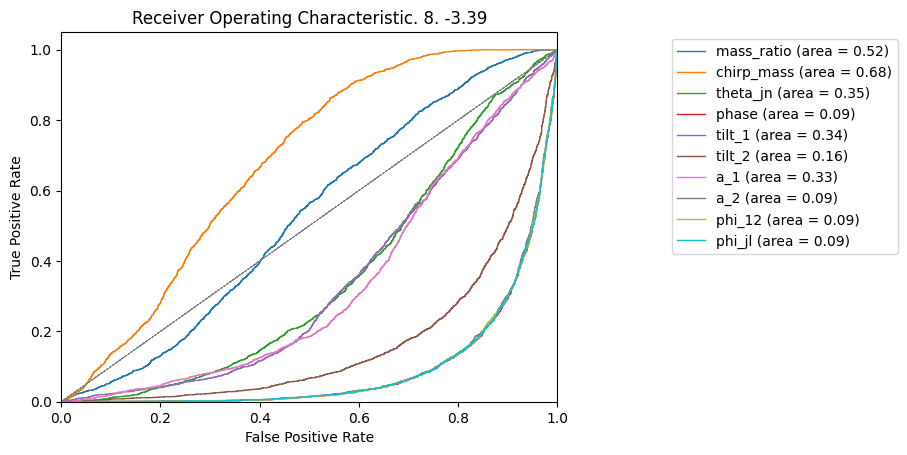

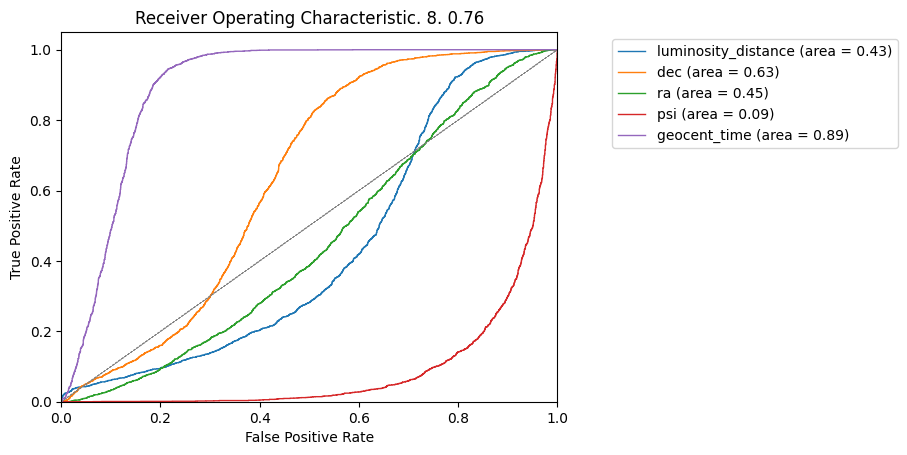

In [99]:
# Start manual training (without pytorch trainer)
import torch.optim as optim
from IPython import display
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
network.to(device)

optimizer = optim.Adam(network.parameters(), lr=network_settings['learning_rate'])

plt.figure(1)
plt.figure(2)

all_val_losses_xe = []

for epoch in range(20):
    
    # enable grads   
    
    train_losses = []
        
    for batch_idx, batch in enumerate(train_data):

        network.train()
        torch.set_grad_enabled(True)

        batch = {key:batch[key].to(device) for key in batch}
        loss = network.training_step(batch, batch_idx)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    avg_epoch_train_loss = sum(train_losses)/len(train_losses)
    
    # Start validation step
    
    val_losses = []
    val_losses_xe = []
    logratios = []
    probabilities = []
    labels = []
    
    for batch_idx, batch in enumerate(val_data):

        batch = {key:batch[key].to(device) for key in batch}

        network.eval()
        torch.set_grad_enabled(False)
        
        loss = network.validation_step(batch, batch_idx)
        val_losses.append(loss.item())
        
        logratios_probs = network.get_logratios_probabilities(batch)
        logratios.append(logratios_probs[0])
        probabilities.append(logratios_probs[1])
        labels.append(logratios_probs[2])
        val_losses_xe.append(logratios_probs[3])
            
    avg_epoch_val_loss = sum(val_losses)/len(val_losses)
    
    logratios_np = torch.concat(logratios).detach().cpu().numpy()
    probabilities_np = torch.concat(probabilities).detach().cpu().numpy()
    labels_np = torch.concat(labels).cpu().numpy()
    
    all_val_losses_xe.append(val_losses_xe)
    
    plt.figure(1)
    plt.clf()

    # Intrinsic variables plotting
    for i, name in enumerate(intrinsic_variables):
        fpr, tpr, thresholds = roc_curve(labels_np[:,i], probabilities_np[:,i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=1, label=f'{name} (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='grey', lw=0.5, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic. {epoch+1}. {avg_epoch_train_loss:.2f}')
        plt.legend(bbox_to_anchor=(1.7, 1), loc="upper right")

    display.display(plt.gcf())  # Display the current figure
    plt.close()  # Close the figure to prevent re-displaying the old figure along with the new in the next iteration

    plt.figure(2)
    
    # Extrinsic variables plotting
    for i, name in enumerate(extrinsic_variables):
        fpr, tpr, thresholds = roc_curve(labels_np[:,i+10], probabilities_np[:,i+10])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=1, label=f'{name} (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='grey', lw=0.5, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic. {epoch+1}. {avg_epoch_val_loss:.2f}')
        plt.legend(bbox_to_anchor=(1.7, 1), loc="upper right")

    display.display(plt.gcf())
    plt.close()

    display.clear_output(wait=True)  # Clear the output to make the update less flickery

    

In [ ]:
A, B = network.get_A_B_samples(batch)

num_pos = len(list(A.values())[0])  # Number of positive examples
num_neg = len(list(B.values())[0]) - num_pos  # Number of negative examples

out = network(batch)  # Evaluate network
loss_tot = 0

logratios = network._get_logratios(
    out
)  # Generates concatenated flattened list of all estimated log ratios
if logratios is not None:
    y = torch.zeros_like(logratios)
    y[:num_pos, ...] = 1
    pos_weight = torch.ones_like(logratios[0]) * num_neg / num_pos
    loss_xe = F.binary_cross_entropy_with_logits(
        logratios, y, reduction="none", pos_weight=pos_weight
    )
    
    # print (torch.mean(loss, axis=0) - np.log(2.0) )
    
    num_ratios = loss_xe.shape[1]
    loss = loss_xe.sum() / num_neg  # Calculates batched-averaged loss
    loss = loss - 2 * np.log(2.0) * num_ratios
                
    loss_tot += loss

# print (loss_tot)

aux_losses = network._get_aux_losses(out)
if aux_losses is not None:
    loss_tot += aux_losses.sum()
    


In [ ]:
aux_losses

In [ ]:
losstens = []
labeltens = []
for i in range(10):
    losstens.append(torch.cat(all_val_losses_xe[i]))
    labeltens.append(torch.cat(labels))

In [ ]:
elosses = torch.stack(losstens)
eprobs = nn.functional.softmax(elosses, dim=1)
elabels = torch.stack(labeltens)

In [ ]:
batchavgloss = torch.sum(elosses, axis=(1)) / 3000 - 2*np.log(2)
batchavgloss.shape

torch.Size([10, 15])

In [ ]:
torch.sum(batchavgloss, axis=1)

tensor([13.2232,  1.1071,  3.3156, 12.6785,  3.4298,  3.8551, 11.0175, -1.1818,
        11.1678, 12.0222], device='cuda:0')

In [ ]:
torch.sum(loss_xe, axis=0) / 200 - 2 * np.log(2.0)

tensor([ 2.9011e-01,  6.3801e+00,  1.5502e-02,  8.8930e-05,  1.0920e+00,
         1.5249e-01,  2.4746e+00,  1.1778e-02,  2.0778e-04,  2.7359e-04,
         2.4204e+00,  9.8124e-03,  4.3871e-01, -5.2249e-04, -6.8958e-01],
       device='cuda:0', grad_fn=<SubBackward0>)

In [ ]:
loss = F.binary_cross_entropy_with_logits(
    logratios_np, labels, reduction="none", pos_weight=pos_weight,
)

AttributeError: 'list' object has no attribute 'size'